In [70]:
import pandas as pd

df = pd.read_csv('/Users/anhnguyendo/Documents/Python machine learning/Credit risk and loan default prediction/credit-risk-analysis-and-loan-default-prediction/data/processed/loan_credit_approval_cleaned.csv')

df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,issue_d,loan_status,application_type,default
0,3600.0,36 months,13.99,123.03,C,C4,10.0,MORTGAGE,55000.0,Not Verified,...,679.0,7.0,0.0,2765.0,29.7,13.0,2015-12-01,Fully Paid,Individual,0
1,24700.0,36 months,11.99,820.28,C,C1,10.0,MORTGAGE,65000.0,Not Verified,...,719.0,22.0,0.0,21470.0,19.2,38.0,2015-12-01,Fully Paid,Individual,0
2,20000.0,60 months,10.78,432.66,B,B4,10.0,MORTGAGE,63000.0,Not Verified,...,699.0,6.0,0.0,7869.0,56.2,18.0,2015-12-01,Fully Paid,Joint App,0
3,10400.0,60 months,22.45,289.91,F,F1,3.0,MORTGAGE,104433.0,Source Verified,...,699.0,12.0,0.0,21929.0,64.5,35.0,2015-12-01,Fully Paid,Individual,0
4,11950.0,36 months,13.44,405.18,C,C3,4.0,RENT,34000.0,Source Verified,...,694.0,5.0,0.0,8822.0,68.4,6.0,2015-12-01,Fully Paid,Individual,0


In [71]:
df.drop('loan_status', axis = 1, inplace = True)

In [72]:
#check missing values
df.isnull().sum()

loan_amnt                0
term                     0
int_rate                 0
installment              0
grade                    0
sub_grade                0
emp_length               0
home_ownership           0
annual_inc               0
verification_status      0
purpose                  0
addr_state               0
dti                      0
delinq_2yrs              0
fico_range_low           0
fico_range_high          0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util             806
total_acc                0
issue_d                  0
application_type         0
default                  0
dtype: int64

In [73]:
#clean and fill the revol_util column with median of consumer's credit card limit usage
df['revol_util'].fillna(df['revol_util'].median(), inplace = True)
df.isnull().sum()

loan_amnt              0
term                   0
int_rate               0
installment            0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
addr_state             0
dti                    0
delinq_2yrs            0
fico_range_low         0
fico_range_high        0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
issue_d                0
application_type       0
default                0
dtype: int64

In [74]:
#drop issue_d
df.drop('issue_d', axis =1, inplace = True)

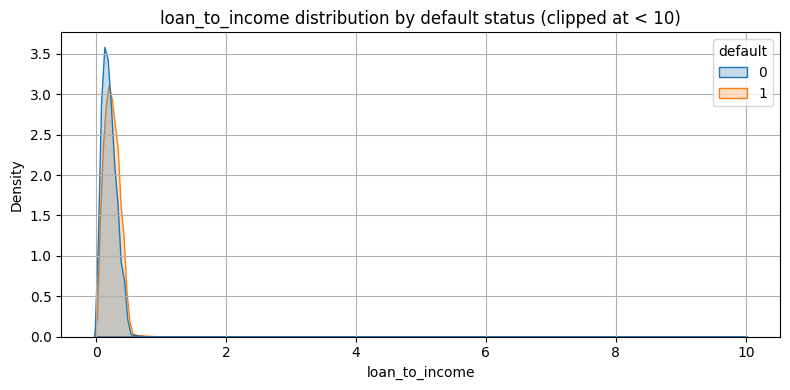

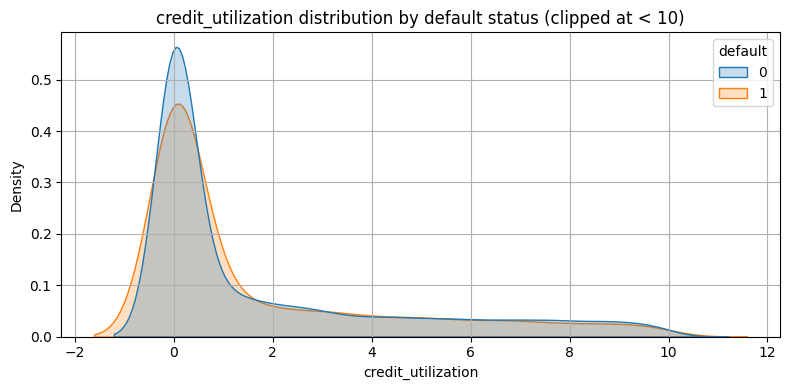

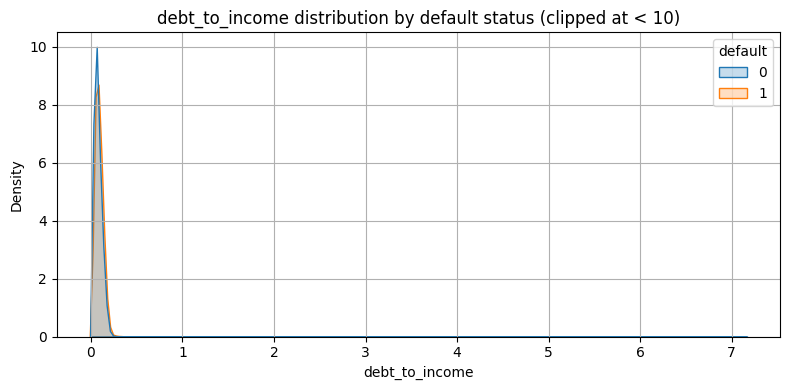

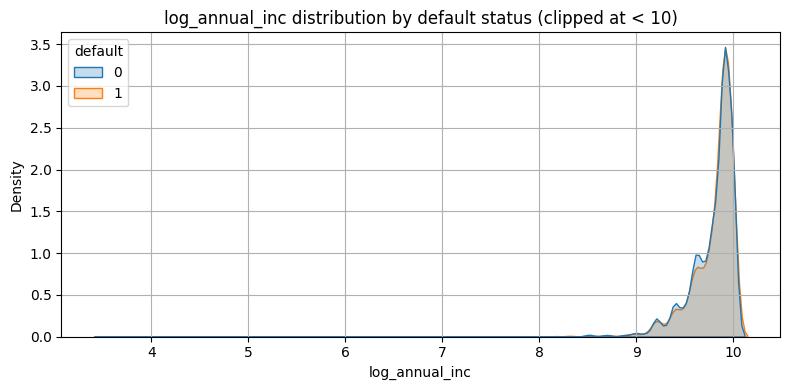

In [75]:
import numpy as np

#loan-to-income ratio
df['loan_to_income'] = df['loan_amnt'] / (df['annual_inc'] + 1e-6)

#credit utilization (approximate since total credit limit is unknown)
df['credit_utilization'] = df['revol_bal'] * df['revol_util'] / 100

#debt-to-income (monthly debt payment over monthly income)
df['debt_to_income'] = df['installment'] / (df['annual_inc'] / 12 + 1e-6)

#log-transformed annual income to reduce skew
df['log_annual_inc'] = np.log(df['annual_inc'] + 1)

import matplotlib.pyplot as plt
import seaborn as sns

# set up multiple plots
features = ['loan_to_income', 'credit_utilization', 'debt_to_income', 'log_annual_inc']

for feature in features:
    # Limit to realistic range (e.g., 0 to 10)
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df[df[feature] < 10], x=feature, hue='default', common_norm=False, fill=True)
    plt.title(f'{feature} distribution by default status (clipped at < 10)')
    plt.xlabel(f'{feature}')
    plt.grid(True)
    plt.tight_layout()  

    plt.savefig(f'/Users/anhnguyendo/Documents/Python machine learning/Credit risk and loan default prediction/credit-risk-analysis-and-loan-default-prediction/figures/{feature}_distribution_by_default_status.png')
    plt.show()



Most borrowers have a loan_to_income ratio < 1, meaning the loan amount is less than their annual income. The default curve is slightly shifted right, suggesting that borrowers with a higher loan relative to their income are slightly more likely to default.

Most value for debt_to_income are concentrated under 1. The default distribution again shifts slightly right, indicating higher debt burdens are associated with higher default rates.

Log transformation creates a tight, right-skewed distribution centered around ~10 (which is ~$22,000 to $30,000 in raw income). Both default and non-default groups are almost overlapping, with the default curve possibly skewed just slightly left. This suggests income alone is not a strong separator, though extremely low-income borrowers may default more.

The credit utilization are the most revealing compare to other graph. Non-defaulters (blue) are tightly centered just above 0.
Defaulters (orange) are more spread out to the right, indicating higher credit utilization. The right tail is heavier for defaulters, meaning they’re more likely to be using a larger portion of their available credit.

In [76]:
# remove negative values from credit_utilization
df = df[df['credit_utilization'] >= 0]


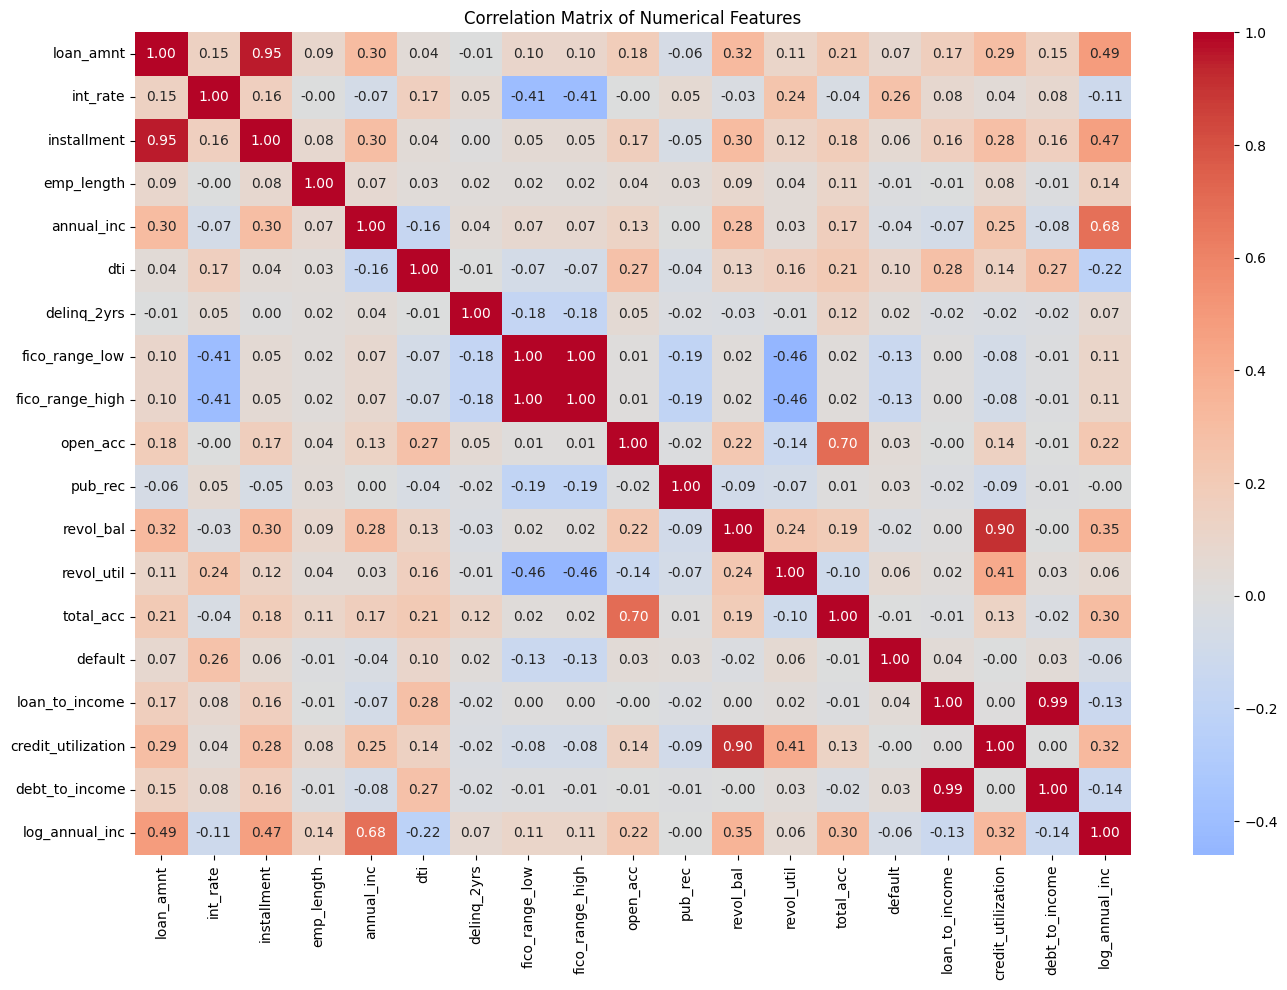

In [77]:
#create correlation heatmap
corr_matrix = df.corr(numeric_only = True)

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = 'coolwarm', center = 0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.savefig('/Users/anhnguyendo/Documents/Python machine learning/Credit risk and loan default prediction/credit-risk-analysis-and-loan-default-prediction/figures/features_correlation_heat_map.png')
plt.show()

Some noticeble feature correlation with default:
- loan_amnt: +0.17 — mild, possibly useful
- installment: +0.16 — same as above (but highly correlated with loan_amnt)
- int_rate: +0.15 — important, often predictive
- credit_utilization: +0.32 — strong candidate
- loan_to_income: +0.30 — also useful
- revol_bal: +0.24
- log_annual_inc: –0.14 — weak but interpretable

Consider dropping pair that have high correlation:
- loan_amnt & installment	0.95
- fico_range_low & fico_range_high	1.00
- revol_bal & credit_utilization	0.90
- loan_to_income & debt_to_income	0.99	Drop one (very close)

In [78]:
#drop some redundant columns
red_col = ['fico_range_high', 'revol_bal', 'loan_to_income']
df.drop(red_col, axis =1 , inplace = True)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_low,open_acc,pub_rec,revol_util,total_acc,application_type,default,credit_utilization,debt_to_income,log_annual_inc
0,3600.0,36 months,13.99,123.03,C,C4,10.0,MORTGAGE,55000.0,Not Verified,...,675.0,7.0,0.0,29.7,13.0,Individual,0,821.205,0.026843,10.915107
1,24700.0,36 months,11.99,820.28,C,C1,10.0,MORTGAGE,65000.0,Not Verified,...,715.0,22.0,0.0,19.2,38.0,Individual,0,4122.240,0.151436,11.082158
2,20000.0,60 months,10.78,432.66,B,B4,10.0,MORTGAGE,63000.0,Not Verified,...,695.0,6.0,0.0,56.2,18.0,Joint App,0,4422.378,0.082411,11.050906
3,10400.0,60 months,22.45,289.91,F,F1,3.0,MORTGAGE,104433.0,Source Verified,...,695.0,12.0,0.0,64.5,35.0,Individual,0,14144.205,0.033312,11.556311
4,11950.0,36 months,13.44,405.18,C,C3,4.0,RENT,34000.0,Source Verified,...,690.0,5.0,0.0,68.4,6.0,Individual,0,6034.248,0.143005,10.434145


In [79]:
#clean and encode categorical variables

#remove the months in term column 
df['term'] = df['term'].str.extract('(\d+)').astype(int)

#One-hot code categorical varibles by using dummies variable
nominal_cols = df.select_dtypes(include = 'object').columns.to_list()
df = pd.get_dummies(df, columns = nominal_cols, drop_first = True)

#scaling and normalizing the numerica data
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(['default']).tolist()

#import StandardScaler and apply to the dataframe
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [80]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Joint App
0,-1.257770,-0.571945,0.158569,-1.218923,1.108717,-0.322166,-1.276775,-0.363814,-0.667208,-0.850925,...,False,False,False,False,False,False,False,False,False,False
1,1.154616,-0.571945,-0.260761,1.437802,1.108717,-0.181486,-0.216161,0.767742,0.596113,1.880962,...,False,False,False,False,False,False,False,False,False,False
2,0.617260,1.748420,-0.514455,-0.039143,1.108717,-0.209622,-0.767889,-0.363814,-0.035548,-1.033051,...,False,False,False,False,False,False,False,False,False,True
3,-0.480318,1.748420,1.932333,-0.583062,-0.856708,0.373261,0.756678,0.767742,-0.035548,0.059704,...,False,False,False,False,False,False,False,False,False,False
4,-0.303105,-0.571945,0.043253,-0.143850,-0.575933,-0.617596,-0.828496,-0.363814,-0.193463,-1.215177,...,False,False,False,False,False,False,False,False,False,False


In [81]:
#save as an engineered and scale dataset
df.to_csv('/Users/anhnguyendo/Documents/Python machine learning/Credit risk and loan default prediction/credit-risk-analysis-and-loan-default-prediction/data/processed/loan_credit_approval_engineered_scale.csv', index = False)